In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls

Mounted at /content/drive
MyDrive


**Load the image datasets**

**i.set_path**

In [3]:
train_dataset='/content/drive/MyDrive/Prisma/Prisma/Prisma_train/Prisma_train'
test_dataset='/content/drive/MyDrive/Prisma/Prisma/Prsima_test/Prsima_test'


**ii.Pre-Processing **

In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3498 images belonging to 4 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dataset,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 1936 images belonging to 4 classes.


**iii.label mappings**

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Bike
1 : Car
2 : Person
3 : Truck


**3.Plot Sample training images**

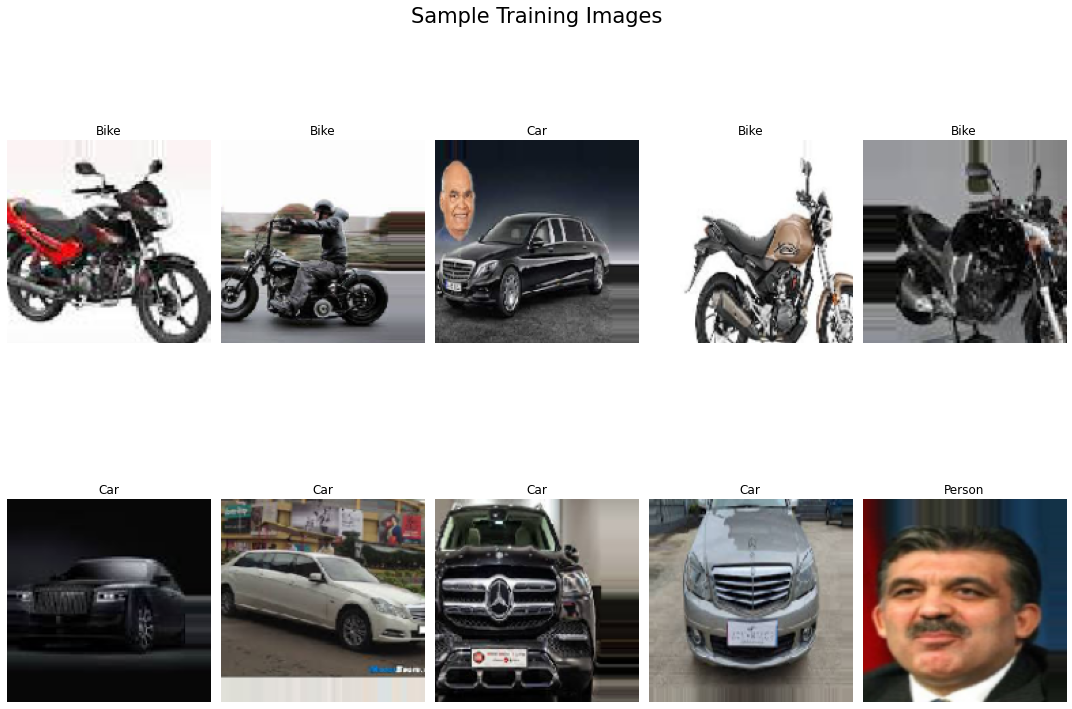

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

**4.Train CNN Model**

**i.Create CNN Model**

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=512, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])
    
    return model

In [10]:
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 activation (Activation)     (None, 148, 148, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0

**ii.Defining Callbacks(learning rate,optimizer,compile CNN model,train model)**

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
optimizer = Adam(learning_rate=0.001)

In [14]:
cnn_model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

In [15]:
history = cnn_model.fit(train_generator,
                         epochs=15,
                         validation_data=test_generator,
                       verbose=1,callbacks=[reduce_lr])

Epoch 1/15
110/110 [==============================] - 1048s 10s/step - loss: 3.1392 - accuracy: 0.6618 - val_loss: 11.5640 - val_accuracy: 0.2366 - lr: 0.0010
Epoch 2/15
110/110 [==============================] - 144s 1s/step - loss: 1.2637 - accuracy: 0.7713 - val_loss: 4.1577 - val_accuracy: 0.3543 - lr: 0.0010
Epoch 3/15
110/110 [==============================] - 144s 1s/step - loss: 0.8386 - accuracy: 0.8013 - val_loss: 1.5564 - val_accuracy: 0.5666 - lr: 0.0010
Epoch 4/15
110/110 [==============================] - 145s 1s/step - loss: 0.6186 - accuracy: 0.8310 - val_loss: 0.6061 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 5/15
110/110 [==============================] - 146s 1s/step - loss: 0.5948 - accuracy: 0.8370 - val_loss: 0.5373 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 6/15
110/110 [==============================] - 144s 1s/step - loss: 0.4885 - accuracy: 0.8465 - val_loss: 0.9162 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 7/15
110/110 [==============================] - 146s 1s

**5. Plotting the Model Metrics**

**i. Plotting training and validation accuracy, loss and learning rate**

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

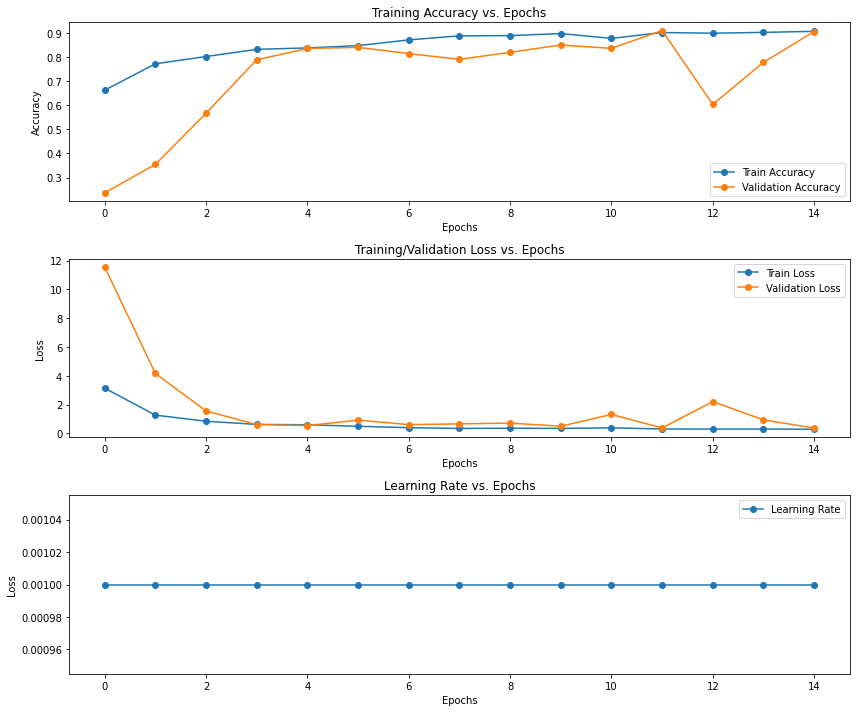

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

**6. Testing the Model on Test Set**

In [18]:
test_dataset = '/content/drive/MyDrive/Prisma/Prisma/Prsima_test/Prsima_test'

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 1936 images belonging to 4 classes.


**7. Model Prediction on the Test Dataset**

In [20]:
predictions = cnn_model.predict(test_generator)

61/61 [==============================] - 23s 378ms/step


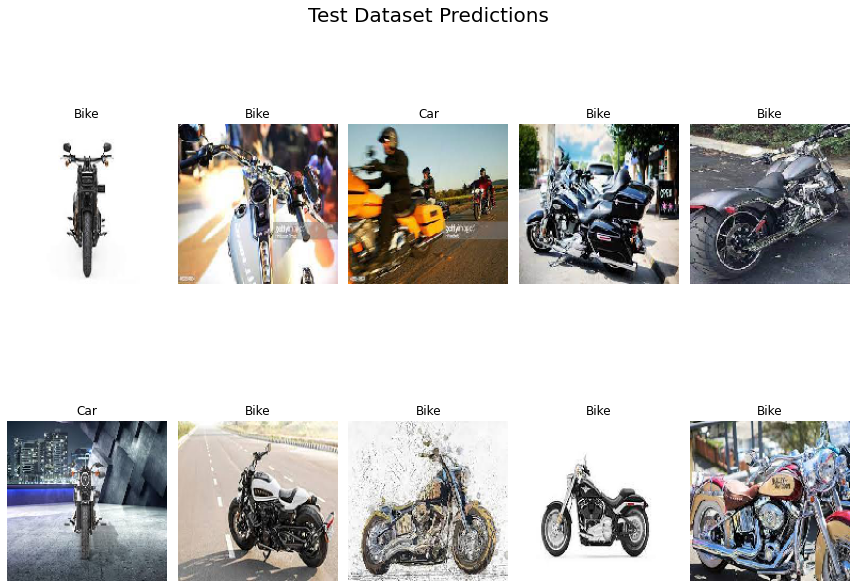

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [22]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

61/61 [==============================] - 23s 382ms/step - loss: 0.3667 - accuracy: 0.9050


In [23]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.36668524146080017
Test Accuracy: 0.9049586653709412


**8. Plotting the Classification Metrics**

**i. Confusion Matrix**

In [24]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

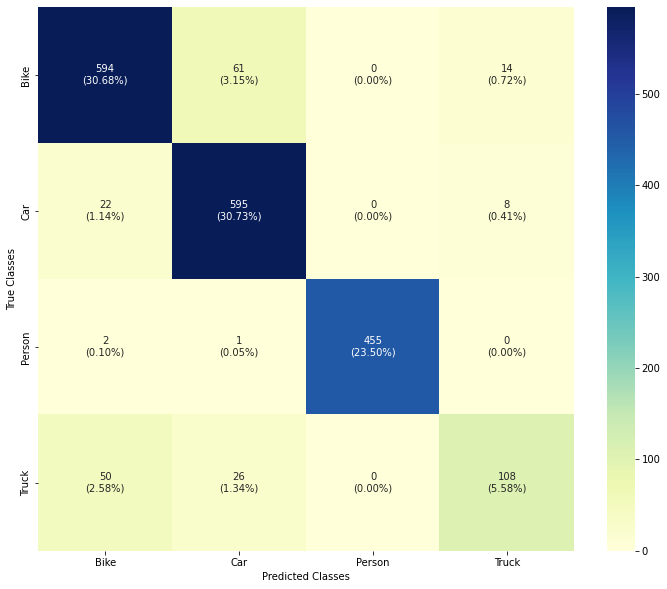

In [25]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [26]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

        Bike       0.89      0.89      0.89       669
         Car       0.87      0.95      0.91       625
      Person       1.00      0.99      1.00       458
       Truck       0.83      0.59      0.69       184

    accuracy                           0.90      1936
   macro avg       0.90      0.86      0.87      1936
weighted avg       0.90      0.90      0.90      1936

